# 9주차 RNN 스팸문자 분류 모델 구현 과제


## **1.데이터 수집-제시된 코드 실행 하기**


[데이터 출처](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)

In [ ]:
# numpy, pandas, matplotlib, seaborn 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/Colab Notebooks/.kaggle'

In [ ]:
# 데이터셋 다운로드
!kaggle datasets download -d uciml/sms-spam-collection-dataset

  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 64.8MB/s]


In [ ]:
!unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [ ]:
# 데이터프레임(df) 생성하기
df = pd.read_csv('./spam.csv', encoding='latin-1')

# 첫행부터 5개 행의 데이터 확인하기
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


## **2. 탐색적 데이터 분석(EDA)**

- 스팸과 스팸이 아닌 데이터의 개수를 확인하세요.
- keras.preprocessing.text에서 제공하는 Tokenizer와 토큰화 후 tokenizer.word_index를 이용하여 스팸인 텍스트 데이터에서 가장 많이 등장한 단어 50개를 출력하세요.
- 이외 필요한 EDA가 있다면 수행하세요.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [ ]:
import string

def rem_punctuation(text):
    no_punc = "".join([x for x in text if x not in string.punctuation])
    return no_punc

df['v2'] = df['v2'].apply(lambda x: rem_punctuation(x))
df['v2'].head()

0    Go until jurong point crazy Available only in ...
1                              Ok lar Joking wif u oni
2    Free entry in 2 a wkly comp to win FA Cup fina...
3          U dun say so early hor U c already then say
4    Nah I dont think he goes to usf he lives aroun...
Name: v2, dtype: object

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['v2']  = df['v2'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['v2'].head()

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, dont, think, he, goes, to, usf, he, l...
Name: v2, dtype: object

In [ ]:
word = []
for i in df['v2']:
  word = word+i
pd.Series(word).value_counts().head(50)

i       2241
to      2240
you     2125
a       1428
the     1322
u       1120
and      970
is       886
in       884
me       786
my       753
for      704
your     677
it       621
of       619
call     576
have     573
on       535
that     515
are      489
now      478
2        478
im       462
so       438
not      430
but      425
or       416
can      406
at       403
do       400
get      386
ur       384
be       384
with     380
if       379
will     378
just     366
we       349
no       332
this     330
its      308
up       303
å        295
4        287
when     285
dont     279
from     278
go       278
ok       277
ltgt     276
dtype: int64

<Axes: >

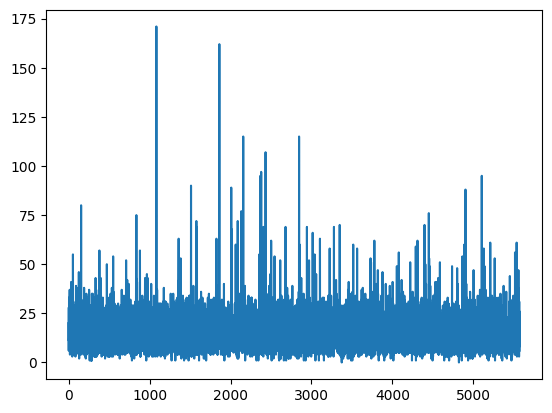

In [ ]:
df['v3'] = df['v2'].apply(lambda x: len(x))
df['v3'].plot()

## **3. 데이터 전처리**

  - 변수 Y에 v1 칼럼의 값을 정수로 인코딩한 데이터를 저장하세요.
  - 변수 X에 v2 칼럼을 토큰화하고, 수치 시퀀스로 바꾼 후, 가장 긴 시퀀스의 길이에 맞춰 패딩을 진행한 데이터를 저장하세요.
  - X, Y를 기반으로 X_train, X_test, Y_train, Y_test를 생성하세요.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM

In [ ]:
df['v1'] = df['v1'].apply(lambda x: 1 if(x=='spam') else 0)
Y = df['v1']
print(Y)

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: v1, Length: 5572, dtype: int64


In [ ]:
MAX_NB_WORDS = 50000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['v2'].values)

X = tokenizer.texts_to_sequences(df['v2'].values)
print(X[:5])

[[47, 447, 4352, 798, 715, 684, 65, 9, 1251, 90, 121, 360, 1252, 155, 2881, 1253, 68, 58, 4353, 138], [49, 317, 1405, 448, 6, 1830], [51, 463, 9, 21, 4, 752, 905, 2, 181, 1831, 1137, 628, 1832, 2209, 264, 2210, 72, 1831, 2, 1833, 2, 318, 463, 2882, 80, 2883, 387, 2884], [6, 231, 144, 24, 361, 2885, 6, 161, 145, 61, 144], [955, 1, 46, 98, 73, 464, 2, 906, 73, 1834, 204, 113, 465]]


In [ ]:
X = pad_sequences(X)
print(X[:5])
print(X.shape)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0   47  447 4352
   798  715  684   65    9 1251   90  121  360 1252  155 2881 1253   68
    58 4353  138]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2,
                                                    random_state = 42,
                                                    stratify=Y)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4457, 171) (4457,)
(1115, 171) (1115,)


## **4. 모델 학습 및 성능평가**

- LSTM 모델을 정의하고, 학습을 진행하세요.
- test 데이터 기반 모델 평가를 진행하세요.

In [ ]:
# RNN 모델 정의를 위한 변수 초기화하기
MAX_NB_WORDS = 50000                # 사용할 단어의 최대 개수(최빈)
MAX_SEQUENCE_LENGTH = X.shape[1]    # 가장 긴 시퀀스 길이
EMBEDDING_DIM = 150                 # 임베딩 차원 정의
rnn_out = 200                       # RNN층 unit 개수

In [ ]:
# LSTM 모델 정의하기
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(SimpleRNN(rnn_out, dropout=0.2, recurrent_dropout=0.2))
model.add((LSTM(rnn_out,dropout = 0.2,recurrent_dropout=0.2)))
# model.add(Dense(2, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 171, 150)          7500000   
                                                                 
 lstm_1 (LSTM)               (None, 200)               280800    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 7,781,001
Trainable params: 7,781,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# RNN모델 학습
history = model.fit(X_train, Y_train,
                    validation_data = (X_test, Y_test),
                    epochs = 10, batch_size=32, verbose = 2)

Epoch 1/10
140/140 - 129s - loss: 0.1399 - accuracy: 0.9547 - val_loss: 0.0572 - val_accuracy: 0.9830 - 129s/epoch - 925ms/step
Epoch 2/10
140/140 - 113s - loss: 0.0298 - accuracy: 0.9910 - val_loss: 0.0533 - val_accuracy: 0.9848 - 113s/epoch - 809ms/step
Epoch 3/10
140/140 - 112s - loss: 0.0110 - accuracy: 0.9973 - val_loss: 0.0558 - val_accuracy: 0.9857 - 112s/epoch - 798ms/step
Epoch 4/10
140/140 - 110s - loss: 0.0092 - accuracy: 0.9982 - val_loss: 0.0603 - val_accuracy: 0.9857 - 110s/epoch - 783ms/step
Epoch 5/10
140/140 - 108s - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0858 - val_accuracy: 0.9695 - 108s/epoch - 769ms/step
Epoch 6/10
140/140 - 108s - loss: 8.3936e-04 - accuracy: 1.0000 - val_loss: 0.0703 - val_accuracy: 0.9839 - 108s/epoch - 773ms/step
Epoch 7/10
140/140 - 114s - loss: 2.0571e-04 - accuracy: 1.0000 - val_loss: 0.0833 - val_accuracy: 0.9857 - 114s/epoch - 812ms/step
Epoch 8/10
140/140 - 108s - loss: 1.0774e-04 - accuracy: 1.0000 - val_loss: 0.0824 - val_accurac

In [ ]:
# model.evaluate로 모델 평가하기
accuracy = model.evaluate(X_test, Y_test)
print('테스트 데이터\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

35/35 [==============================] - 3s 89ms/step - loss: 0.1000 - accuracy: 0.9865
테스트 데이터
  Loss: 0.100
  Accuracy: 0.987


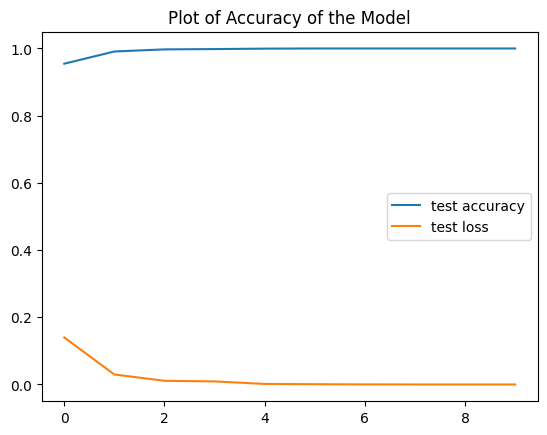

In [ ]:
# 테스트 데이터 손실(Loss)과 정확도(Accuracy)를 그래프로 나타내기
plt.title('Plot of Accuracy of the Model')
plt.plot(history.history['accuracy'], label='test accuracy')
plt.plot(history.history['loss'], label='test loss')
plt.legend()
plt.show()

#**[스스로 정리하기]**
- 수업시간에 한 내용을 기반으로 설명(?)을 자연어처리하여 제품이 스팸인지 그냥 햄인지 구별하는 RNN을 만들고 실행시켜보았다. 하지만 어떤 이유에선지 accuracy가 처음부터 1이 나왔다. 코드를 검토해보니 spam여부를 인코딩하는 과정을 두번 실행 하여서 Y가 모두 0인 상태였다. 다시 오류를 수정하여 처음부터 다시 실행하여서 옳은 결과를 얻을 수 있었다.